Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing necessary modules

In [ ]:

import tensorflow as tf
from keras import layers,models,applications
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten,Input, Lambda, GlobalMaxPooling2D,Conv2D, GlobalMaxPooling1D, Conv1D
from keras.models import Model,Sequential
from keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
 ! pip install -q kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
! kaggle datasets download -d tushar5harma/plant-village-dataset-updated

 99% 0.99G/1.00G [00:12<00:00, 101MB/s]
100% 1.00G/1.00G [00:12<00:00, 87.1MB/s]


In [ ]:
!mkdir datasets
! unzip plant-village-dataset-updated.zip -d datasets

Streaming output truncated to the last 5000 lines.
  inflating: datasets/Tomato/Train/Septoria Leaf Spot/a3938779-9d9f-4e45-a397-7b5abd13f6ba___JR_Sept.L.S 2700.JPG  
  inflating: datasets/Tomato/Train/Septoria Leaf Spot/a4467299-5237-45f5-bb9b-9fd69f7a2b1a___Matt.S_CG 7719.JPG  
  inflating: datasets/Tomato/Train/Septoria Leaf Spot/a45b192c-f31e-4ca1-bf4a-10ff1060e658___Matt.S_CG 7512.JPG  
  inflating: datasets/Tomato/Train/Septoria Leaf Spot/a45bce54-4c25-4d5d-a9a9-fbc76436844c___Matt.S_CG 6523.JPG  
  inflating: datasets/Tomato/Train/Septoria Leaf Spot/a46ff722-2186-4645-9018-01e8e20cfa2a___Matt.S_CG 6511.JPG  
  inflating: datasets/Tomato/Train/Septoria Leaf Spot/a4880706-e191-43ff-a5a7-bd0f0c03aa2d___Keller.St_CG 1851.JPG  
  inflating: datasets/Tomato/Train/Septoria Leaf Spot/a494e2ac-9dbe-47e5-9963-3e99f8eb9d2e___Matt.S_CG 6062.JPG  
  inflating: datasets/Tomato/Train/Septoria Leaf Spot/a49c7f28-4b67-4d95-b79b-26a52dc8b9e5___Matt.S_CG 7583.JPG  
  inflating: datasets/Tomato/Tra

Import & Visualising Data

In [ ]:

IMAGE_SIZE = 256
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
validation_datagen= ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
        '/content/datasets/Corn (Maize)/Train',
        shuffle=True,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

valid_set = validation_datagen.flow_from_directory(
        '/content/datasets/Corn (Maize)/Val',
        shuffle=False,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

test_set= test_datagen.flow_from_directory(
        '/content/datasets/Corn (Maize)/Test',
        shuffle=False,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 7316 images belonging to 4 classes.
Found 1645 images belonging to 4 classes.
Found 188 images belonging to 4 classes.


In [ ]:
labels = train_set.classes
class_names = list(train_set.class_indices.keys())

In [ ]:
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patches=196, projection_dim=768, patch_size=16):
        super().__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = self.add_weight(
            "position_embedding", shape=(1, num_patches, projection_dim),
            initializer="random_normal", trainable=True)
        self.autoencoder = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(projection_dim, activation='relu')   ])

    def call(self, images):
        # Use extract_patches to divide images into patches
        patches = tf.image.extract_patches(
            images=images, sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1], padding='VALID')
        # Reshape to the (num_patches, projection_dim)
        patches = layers.Reshape((self.num_patches, self.patch_size * self.patch_size * 3))(patches)
        projected_patches = self.projection(patches)
        encoded= projected_patches + self.position_embedding
        autoencoded_patches = self.autoencoder(encoded)
        return autoencoded_patches

In [ ]:
def create_vit_classifier(input):
    #input = layers.Input(shape=(224, 224, 3))

    patches = PatchEmbedding(num_patches=196, projection_dim=64)(input)

    for _ in range(3):  # We use just one transformer block for simplicity
        x1 = layers.LayerNormalization(epsilon=1e-6)(patches)
        attention_output = layers.MultiHeadAttention(num_heads=2, key_dim=64)(x1, x1)
        x2 = layers.Add()([attention_output, patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(64, activation='relu')(x3)
        patches = layers.Add()([x3, x2])

    #representation = layers.Flatten()(patches)
    trans_output = layers.Dense(128, activation='relu')(patches)
    trans_output = layers.GlobalMaxPooling1D()(trans_output)
    return trans_output

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,MaxPooling1D, Flatten, Dense

def cnn_model(input):
  #input = layers.Input(shape=(224, 224, 3))

  l1 = Conv2D(128, kernel_size=(3, 3), activation='relu')(input)
  l1 = Conv2D(64, kernel_size=(3,3), activation='relu')(l1)
  l1 = MaxPooling2D(pool_size=(2,2))(l1)

  l2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(l1)
  l2 = Conv2D(32, kernel_size=(3,3), activation='relu')(l2)

  #l2 = Flatten()(l2)
  cnn_output = GlobalMaxPooling2D()(l2)

  #cnn_output = Dense(128, activation='relu')(l2)

  return cnn_output

In [ ]:
#cnn_model(input).shape

In [ ]:
#create_vit_classifier(input).shape

In [ ]:
input = layers.Input(shape=(224, 224, 3))
x1 = cnn_model(input)
x1 = tf.keras.layers.Dense(64, activation='relu')(x1)

In [ ]:

x2 = create_vit_classifier(input)
x2=tf.keras.layers.Dense(64, activation='relu')(x2)

combined_output = layers.Concatenate()([x1,x2])
output = layers.Dense(4, activation='softmax')(combined_output)

fusion_model = models.Model(inputs= input, outputs=output)


In [ ]:
fusion_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 patch_embedding (PatchEmbe  (None, 196, 64)              70080     ['input_1[0][0]']             
 dding)                                                                                           
                                                                                                  
 layer_normalization (Layer  (None, 196, 64)              128       ['patch_embedding[0][0]']     
 Normalization)                                                                                   
                                                                                              

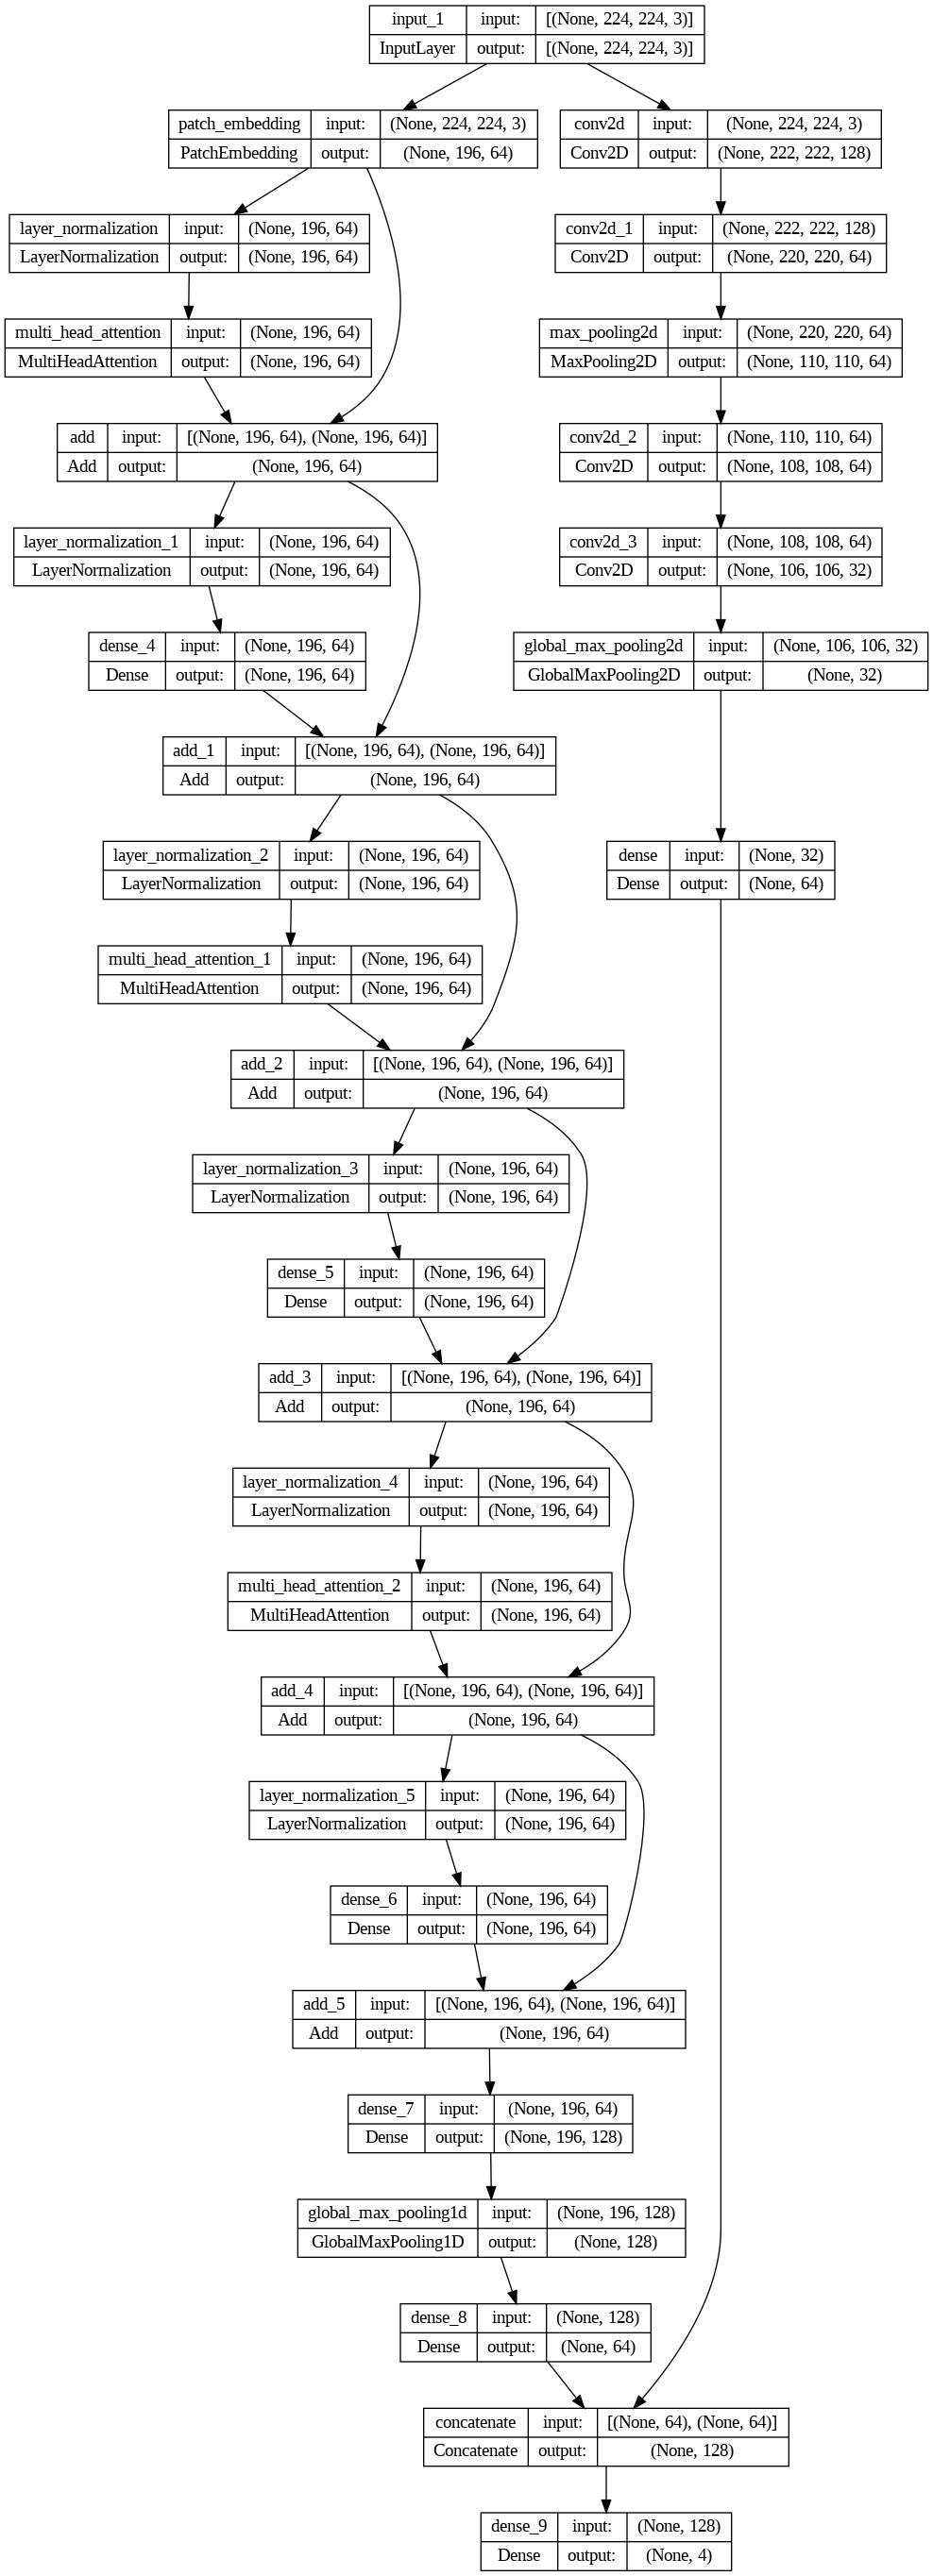

In [ ]:
from keras.utils import plot_model
plot_model(fusion_model, "/content/drive/MyDrive/project/graph.jpg", show_shapes=True)

In [ ]:
fusion_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy","categorical_accuracy"])

Training the model

In [ ]:
model_history=fusion_model.fit(train_set , validation_data=valid_set, epochs=25,validation_steps=32 ,verbose=1)

Epoch 1/25
229/229 [==============================] - 143s 526ms/step - loss: 0.4693 - accuracy: 0.8071 - categorical_accuracy: 0.8071 - val_loss: 0.6228 - val_accuracy: 0.7188 - val_categorical_accuracy: 0.7188
Epoch 2/25
229/229 [==============================] - 114s 495ms/step - loss: 0.2785 - accuracy: 0.8897 - categorical_accuracy: 0.8897 - val_loss: 0.2424 - val_accuracy: 0.8506 - val_categorical_accuracy: 0.8506
Epoch 3/25
229/229 [==============================] - 114s 497ms/step - loss: 0.2249 - accuracy: 0.9112 - categorical_accuracy: 0.9112 - val_loss: 0.3066 - val_accuracy: 0.8125 - val_categorical_accuracy: 0.8125
Epoch 4/25
229/229 [==============================] - 116s 509ms/step - loss: 0.1989 - accuracy: 0.9225 - categorical_accuracy: 0.9225 - val_loss: 0.4784 - val_accuracy: 0.7822 - val_categorical_accuracy: 0.7822
Epoch 5/25
229/229 [==============================] - 113s 495ms/step - loss: 0.1741 - accuracy: 0.9288 - categorical_accuracy: 0.9288 - val_loss: 0.234

In [ ]:
fusion_model.save("/content/drive/MyDrive/project/Vit+cnn_final.keras")

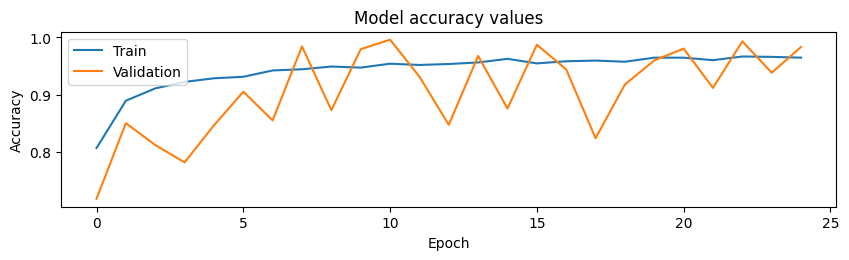

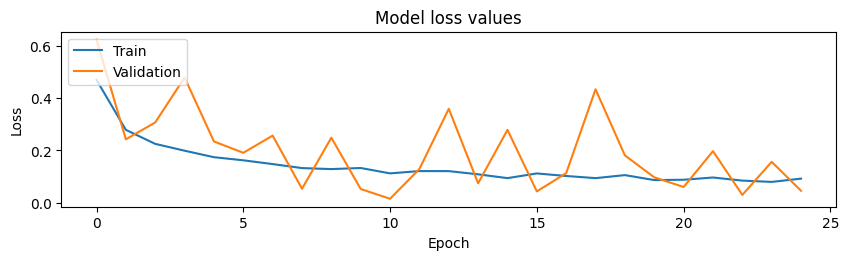

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(2,1,2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model Evaluation

In [ ]:
fusion_model.evaluate(test_set)

6/6 [==============================] - 3s 573ms/step - loss: 0.0921 - accuracy: 0.9734 - categorical_accuracy: 0.9734


[0.0921235904097557, 0.9734042286872864, 0.9734042286872864]

In [ ]:
predictions = fusion_model.predict(test_set)
predicted_classes = np.argmax(predictions, axis=1)

6/6 [==============================] - 1s 76ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
true_labels= test_set.classes

#CLASSIFICATION REPORT
import pandas as pd
cr =classification_report(true_labels,predicted_classes,output_dict = True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.955556,0.955556,0.955556,45.000000
1,0.979592,1.000000,0.989691,48.000000
2,1.000000,1.000000,1.000000,47.000000
3,0.957447,0.937500,0.947368,48.000000
accuracy,0.973404,0.973404,0.973404,0.973404
macro avg,0.973149,0.973264,0.973154,188.000000
weighted avg,0.973286,0.973404,0.973292,188.000000


[[43  0  0  2]
 [ 0 48  0  0]
 [ 0  0 47  0]
 [ 2  1  0 45]]


<Axes: >

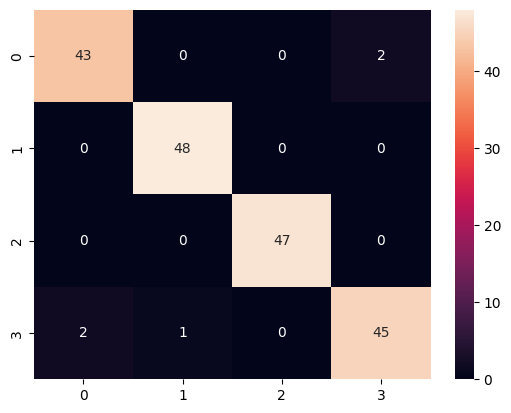

In [ ]:
cm = confusion_matrix(true_labels,predicted_classes)
print(cm)

import seaborn as sns
sns.heatmap(cm, annot=True)